In [68]:
# Import necessary libraries for the simulation
from mesa import Agent, Model  # Mesa library for agent-based modeling
from mesa.time import RandomActivation  # Scheduler for agent activation
from mesa.space import MultiGrid  # Multi-dimensional grid for agent movement
from mesa.datacollection import DataCollector  # Collects data during the simulation
import numpy as np  # Numerical operations library
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.animation import FuncAnimation  # Animation support for matplotlib
import noise  # Library for Perlin noise generation


In [69]:
class Creature(Agent):
    """
    Represents an agent in the simulation with evolutionary traits.

    Attributes:
    - unique_id (int): A unique identifier for each agent.
    - model (EvolutionModel): Reference to the simulation model.
    - trait (float): Evolutionary trait of the agent.
    - environment_factor (float): Environmental factor at the agent's location.
    - mutation_rate (float): Rate at which the agent's trait can mutate.
    """

    def __init__(self, unique_id, model, trait=None, mutation_rate=0.01):
        """
        Initialize a new Creature agent.

        Parameters:
        - unique_id (int): A unique identifier for the agent.
        - model (EvolutionModel): Reference to the simulation model.
        - trait (float, optional): Initial trait of the agent. If not provided, a random trait is assigned.
        - mutation_rate (float, optional): Rate at which the agent's trait can mutate.
        """
        super().__init__(unique_id, model)
        self.trait = trait if trait is not None else model.random.random()
        self.environment_factor = model.environment_factor
        self.mutation_rate = mutation_rate

    def move(self):
        """
        Move the agent to a neighboring cell based on environmental factors.
        """
        current_environment_factor = self.model.environment_grid[self.pos[0]][self.pos[1]]
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        neighbor_environment_factors = [self.model.environment_grid[pos[0]][pos[1]] for pos in neighborhood]

        if current_environment_factor > min(neighbor_environment_factors):
            min_environment_factor_pos = neighborhood[neighbor_environment_factors.index(min(neighbor_environment_factors))]
            self.model.grid.move_agent(self, min_environment_factor_pos)

    def step(self):
        """
        Execute one step of the agent, including movement and trait evolution.
        """
        self.move()
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        neighbor_traits = [neighbor.trait for neighbor in neighbors]
        avg_neighbor_trait = np.mean(neighbor_traits) if neighbors else self.trait
        trait_difference = avg_neighbor_trait - self.trait
        self.trait += self.model.selection_pressure * 0.1 * trait_difference * self.environment_factor

        if self.model.random.random() < self.mutation_rate:
            self.trait += self.model.random.normalvariate(0, 0.1)


In [70]:
class EvolutionModel(Model):
    """
    Represents the main evolutionary simulation model.

    Attributes:
    - N (int): Number of agents in the simulation.
    - width (int): Width of the grid.
    - height (int): Height of the grid.
    - environment_factor (float): Global environmental factor affecting all agents.
    - mutation_rate (float): Rate at which agent traits can mutate.
    - selection_pressure (float): Strength of selection pressure in the evolution process.
    - initial_traits (list, optional): List of initial traits for agents. If not provided, random traits are assigned.
    - terrain (numpy.ndarray, optional): Grid of environmental factors. If not provided, it's generated randomly.
    """

    def __init__(self, N, width, height, environment_factor, mutation_rate, selection_pressure, initial_traits=None, terrain=None):
        """
        Initialize a new EvolutionModel.

        Parameters:
        - N (int): Number of agents in the simulation.
        - width (int): Width of the grid.
        - height (int): Height of the grid.
        - environment_factor (float): Global environmental factor affecting all agents.
        - mutation_rate (float): Rate at which agent traits can mutate.
        - selection_pressure (float): Strength of selection pressure in the evolution process.
        - initial_traits (list, optional): List of initial traits for agents. If not provided, random traits are assigned.
        - terrain (numpy.ndarray, optional): Grid of environmental factors. If not provided, it's generated randomly.
        """
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.environment_factor = environment_factor
        self.mutation_rate = mutation_rate
        self.selection_pressure = selection_pressure
        self.environment_grid = terrain if terrain is not None else np.random.normal(0.5, 0.1, (width, height))

        if initial_traits:
            for i in range(self.num_agents):
                agent_trait = initial_traits[i % len(initial_traits)]
                agent = Creature(i, self, trait=agent_trait, mutation_rate=mutation_rate)
                x = np.random.choice(self.grid.width)
                y = np.random.choice(self.grid.height)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
        else:
            for i in range(self.num_agents):
                agent = Creature(i, self, mutation_rate=mutation_rate)
                x = np.random.choice(self.grid.width)
                y = np.random.choice(self.grid.height)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)

        self.datacollector = DataCollector(agent_reporters={"x": lambda a: a.pos[0],
                                                           "y": lambda a: a.pos[1],
                                                           "Trait": lambda a: a.trait,
                                                           "Environment Factor": "environment_factor"})

    def step(self):
        """
        Execute one step of the model, updating the environment grid and advancing the simulation.
        """
        self.environment_grid = np.clip(self.environment_grid, 0, 1)
        self.datacollector.collect(self)
        self.schedule.step()


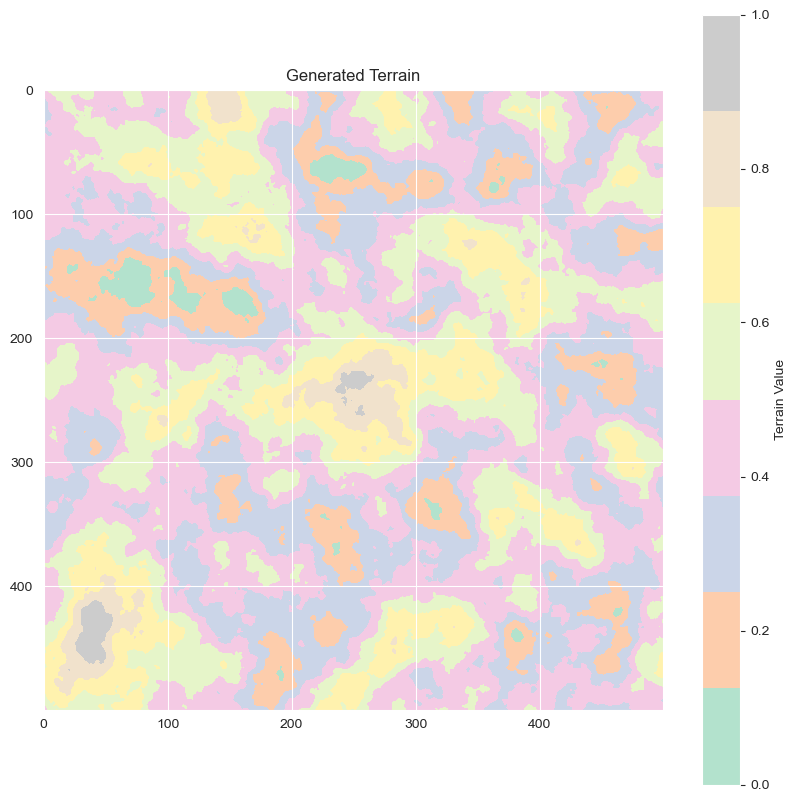

In [71]:
def generate_terrain(width, height, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0):
    """
    Generate a grid of environmental factors using Perlin noise.

    Parameters:
    - width (int): Width of the grid.
    - height (int): Height of the grid.
    - scale (float, optional): Scale of the noise.
    - octaves (int, optional): Number of octaves in the noise.
    - persistence (float, optional): Persistence of the noise.
    - lacunarity (float, optional): Lacunarity of the noise.

    Returns:
    - numpy.ndarray: Grid of environmental factors.
    """
    terrain = np.zeros((width, height))

    for i in range(width):
        for j in range(height):
            terrain[i][j] = noise.pnoise2(i/scale, j/scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity, repeatx=1024, repeaty=1024, base=42)

    # Normalize the values to the range [0, 1]
    terrain = (terrain - np.min(terrain)) / (np.max(terrain) - np.min(terrain))

    return terrain

def display_terrain(terrain):
    """
    Display a visualization of the generated terrain.

    Parameters:
    - terrain (numpy.ndarray): Grid of environmental factors.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(terrain, cmap='Pastel2')
    plt.colorbar(label='Terrain Value')
    plt.title('Generated Terrain')
    plt.show()

# Example usage:
width = 500
height = 500    
terrain = generate_terrain(width, height, scale=100.0, octaves=6, persistence=0.5, lacunarity=2.0)
display_terrain(terrain)


In [72]:
# Run the model for a certain number of steps
user_defined_environment_factor = 0.001
user_defined_mutation_rate = 100
user_defined_initial_traits = [0.1, 0.9, 0.6, 0.4, 0.2, 0.8, 0.3, 0.7, 0.5,-10,20]
user_defined_selection_pressure = 0.001
  # Scale the terrain values to the range [0, 0.7]
N_steps = 2500  # Increase this to get a longer time series
N_agents = 5000
width = 500
height = 500

# Create an instance of the EvolutionModel
model = EvolutionModel(
    N_agents,
    width,
    height,
    user_defined_environment_factor,
    user_defined_mutation_rate,
    user_defined_selection_pressure,
    initial_traits=user_defined_initial_traits,
    terrain=terrain  # Assuming 'terrain' is predefined or generated earlier
)

# Run the simulation for the specified number of steps
for i in range(N_steps):
    model.step()

# Extract and visualize data collected during the simulation
agent_data = model.datacollector.get_agent_vars_dataframe()

# Get data for the last step
last_step_data = agent_data.xs(N_steps-1, level="Step")

# Unstack the data for plotting
unstacked_data = last_step_data.unstack()


Step
0       1.317200
1       1.315932
2       1.317427
3       1.317220
4       1.315702
          ...   
2495    1.270771
2496    1.269990
2497    1.270141
2498    1.270879
2499    1.268529
Name: Trait, Length: 2500, dtype: float64
                x    y     Trait  Environment Factor
Step AgentID                                        
0    0        253  236  0.100000               0.001
     1        279  201  0.900000               0.001
     2        373  437  0.600000               0.001
     3        148   71  0.400000               0.001
     4         84  265  0.200000               0.001
...           ...  ...       ...                 ...
2499 4995     448  238 -1.884694               0.001
     4996     363  383 -6.775463               0.001
     4997     201   53  0.472242               0.001
     4998     336  301  3.429652               0.001
     4999      82  246 -0.345648               0.001

[12500000 rows x 4 columns]


Text(0.5, 1.0, 'Evolution Simulation Trait Average Over Time')

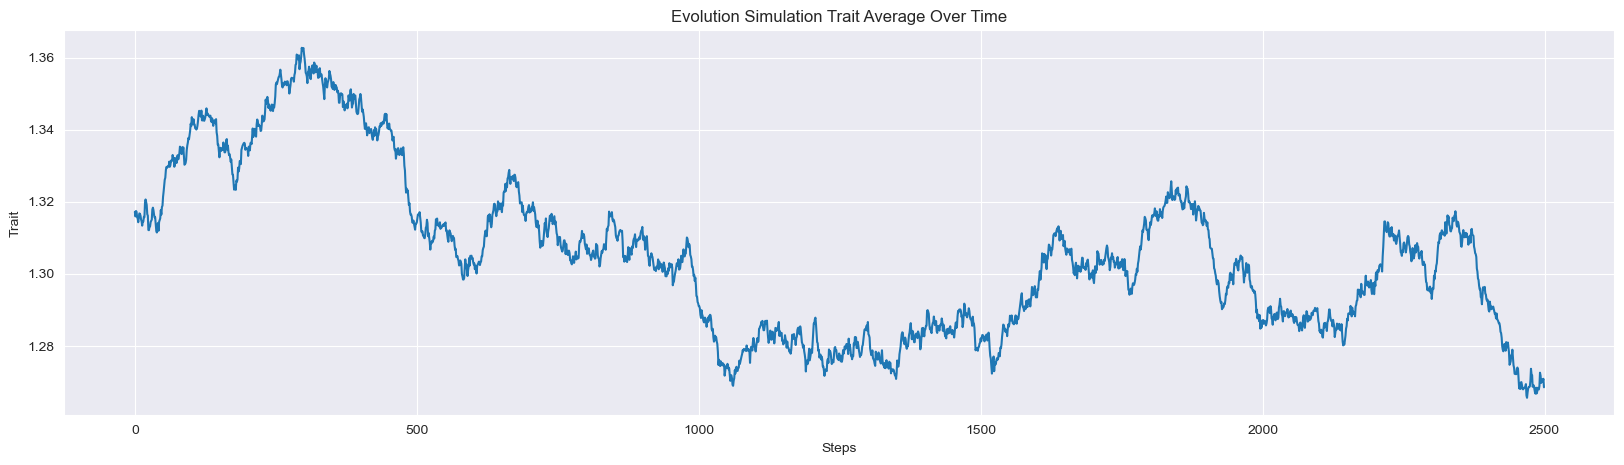

In [73]:
# Plot the trait of the agents
average_traits = agent_data.groupby("Step")['Trait'].mean()

# Print the average trait values for each step
print(average_traits)

# Create a figure for the plot
plt.figure(figsize=(20, 5))

# Print the raw agent data (optional)
print(agent_data)

# Plot the average trait over time
average_traits.plot()

# Set labels and title for the plot
plt.xlabel('Steps')
plt.ylabel('Trait')
plt.title(f'Evolution Simulation Trait Average Over Time')


In [74]:
import plotly.express as px

# Assuming 'last_step_data' is your DataFrame containing data for the last step
fig = px.scatter(
    last_step_data,
    x='x',
    y='y',
    color='Trait',
    size='Environment Factor',
    hover_data=['Trait', 'Environment Factor']
)

# Customize the appearance of the plot
fig.update_layout(
    coloraxis=dict(colorscale='Viridis'),
    title='Spatial Distribution of Trait and Environment Factor',
    xaxis_title='X',
    yaxis_title='Y'
)

# Show the interactive plot
fig.show()

In [75]:
from mpl_toolkits.mplot3d import Axes3D

# Function to update the plot
fig = plt.figure(figsize=(20, 10))  # Create a figure
agent_data_reset = agent_data.reset_index()

def update(i):
    """
    Update the 3D scatter plot and add a heatmap for the spatial distribution of trait values.

    Parameters:
    - i (int): The step index to update the plot for.
    """
    print((i / N_steps) * 100)
    fig.clear()

    # Filter the data for each step
    step_data = agent_data_reset[agent_data_reset["Step"] == i]

    # Create a 3D scatter plot
    ax = fig.add_subplot(121, projection='3d')
    sc_local = ax.scatter(
        step_data["x"],
        step_data["y"],
        step_data["Trait"].values,
        c=step_data["Trait"].values,
        cmap='Spectral'
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Trait')
    ax.set_title(f'Spatial Distribution Step {i}')

    # Add a heatmap to the second subplot
    ax2 = fig.add_subplot(122)
    heatmap_data = np.histogram2d(
        step_data["x"],
        step_data["y"],
        weights=step_data["Trait"].values,
        bins=50
    )[0]
    ax2.imshow(heatmap_data, extent=(0, width, 0, height), alpha=0.5, cmap='inferno')
    ax2.set_title('Heatmap of Trait Distribution')

    # Add a colorbar
    fig.colorbar(sc_local, ax=ax, label='Environment Factor')


<Figure size 2000x1000 with 0 Axes>

In [76]:
# Create an animation
ani = FuncAnimation(fig, update, frames = N_steps, repeat=True)

# Save the animation as a video file
ani.save('onlyMUT.mp4', writer='ffmpeg')

0.0
0.0
0.04
0.08
0.12
0.16
0.2
0.24
0.27999999999999997
0.32
0.36
0.4
0.44
0.48
0.52
0.5599999999999999
0.6
0.64
0.6799999999999999
0.72
0.76
0.8
0.84
0.88
0.9199999999999999
0.96
1.0
1.04
1.08
1.1199999999999999
1.16
1.2
1.24
1.28
1.32
1.3599999999999999
1.4000000000000001
1.44
1.48
1.52
1.5599999999999998
1.6
1.6400000000000001
1.68
1.72
1.76
1.7999999999999998
1.8399999999999999
1.8800000000000001
1.92
1.96
2.0
2.04
2.08
2.12
2.16
2.1999999999999997
2.2399999999999998
2.2800000000000002
2.32
2.36
2.4
2.44
2.48
2.52
2.56
2.6
2.64
2.68
2.7199999999999998
2.76
2.8000000000000003
2.8400000000000003
2.88
2.92
2.96
3.0
3.04
3.08
3.1199999999999997
3.16
3.2
3.2399999999999998
3.2800000000000002
3.32
3.36
3.4000000000000004
3.44
3.4799999999999995
3.52
3.56
3.5999999999999996
3.64
3.6799999999999997
3.7199999999999998
3.7600000000000002
3.8
3.84
3.88
3.92
3.9600000000000004
4.0
4.04
4.08
4.12
4.16
4.2
4.24
4.279999999999999
4.32
4.36
4.3999999999999995
4.44
4.4799999999999995
4.52
4.560000